In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization,Conv2D, Input, Dense, SimpleRNN, Dropout, MaxPooling2D, GlobalMaxPool2D, LSTM, GRU, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


from skimage.transform import resize

import numpy as np
import glob
import os
import cv2

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

import pandas as pd
from keras.utils import to_categorical
from skimage import io
import random

%matplotlib inline


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Define Dataset
dataPath = '/content/drive/MyDrive/TA/images/train'
print(os.listdir('/content/drive/MyDrive/TA/images/train'))

['BukanPenghuni', 'Penghuni']


In [4]:
dirList = glob.glob(dataPath+'/*') # list of all directories in dataPath
dirList.sort() # sorted in alphabetical order


In [5]:
# Constants for image resizing and HOG parameters also folds
img_size_h, img_size_w = 224, 224
hog_pixels_per_cell = (8, 8)
hog_cells_per_block = (2, 2)
num_folds = 5

In [6]:
BukanPenghuni = glob.glob(dirList[0]+'/*')
Penghuni = glob.glob(dirList[1]+'/*')

# Load images
images = []
labels = []

for i in BukanPenghuni:
    image=tf.keras.preprocessing.image.load_img(i, color_mode="rgb",
    target_size= (img_size_h, img_size_w))
    image=np.array(image)
    images.append(image)
    labels.append(0)
for i in Penghuni:
    image=tf.keras.preprocessing.image.load_img(i, color_mode="rgb",
    target_size= (img_size_h, img_size_w))
    image=np.array(image)
    images.append(image)
    labels.append(1)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [7]:
# seq_length = 64
# sequences_hog = []
# for i in range(0, len(images), seq_length):
#     seq_hog = extract_hog_features(images[i:i + seq_length])
#     sequences_hog.append(seq_hog)

# data_hog = np.array(sequences_hog)

In [8]:
number = 0
batch_size = 21
images_exp = images
labels_exp = labels
datagen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1.,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   cval=0)
train_generator = datagen.flow(images,labels,batch_size)
for batch_images, batch_labels in train_generator:
  if (number == 10):
    break
  images_exp = np.concatenate((images_exp, batch_images))
  labels_exp = np.concatenate((labels_exp, batch_labels))
  number+=1
# images_exp, labels_exp = next(train_generator)

In [9]:
# Function to extract HOG features from an image
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog_feature = hog(gray_image, pixels_per_cell=hog_pixels_per_cell, cells_per_block=hog_cells_per_block)
    return hog_feature


In [10]:
data_hog = []
for image in images_exp:
  tmp_hog = extract_hog_features(image)
  data_hog.append(tmp_hog)

data_hog = np.array(data_hog)

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_hog, labels_exp, test_size=0.2, random_state=42)

# normalizing
X_train = X_train / 255
X_test = X_test / 255

In [12]:
print('Jumlah total data: ',len(data_hog))
print('Jumlah X_train: ',len(X_train))
print('Jumlah X_test',len(X_test))
print('Jumlah y_train',len(y_train))
print('Jumlah y_test',len(y_test))
print('X train shape: ',X_train.shape)
print('X test shape: ',X_test.shape)
print('y train shape: ',y_train.shape)
print('y test shape: ',y_test.shape)


Jumlah total data:  1453
Jumlah X_train:  1162
Jumlah X_test 291
Jumlah y_train 1162
Jumlah y_test 291
X train shape:  (1162, 26244)
X test shape:  (291, 26244)
y train shape:  (1162,)
y test shape:  (291,)


In [13]:
# Normalize the feature data (optional but can be beneficial for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

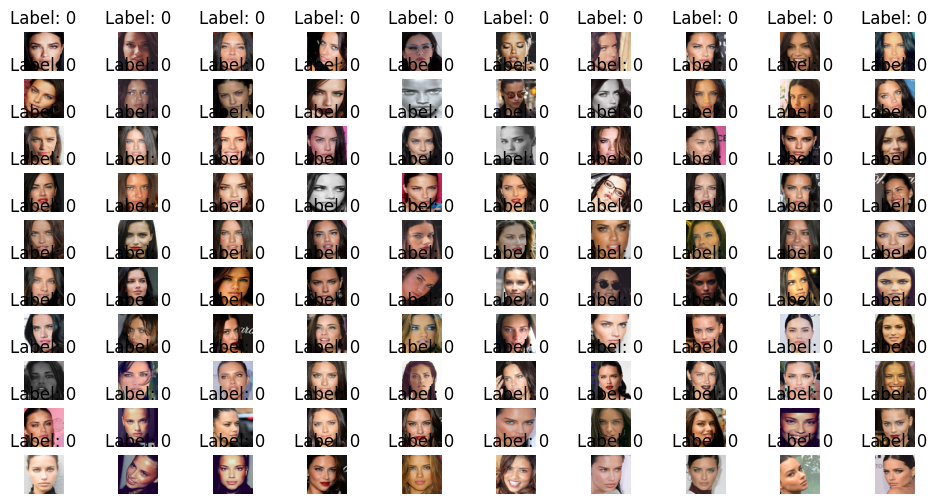

In [14]:
num_images_to_display = len(images)
fig, axes = plt.subplots(10, 10, figsize=(12, 6))
num = 0
row = 0
for i in range(num_images_to_display):
    if (num == 100):
      break
    if(labels[i] == 0):
        numUsed = num-((row)*10)
        axes[row][numUsed].imshow(images[i])
        axes[row][numUsed].set_title(f"Label: {labels[i]}")
        axes[row][numUsed].axis('off')
        num+=1
        if (num%10)==0:
          row+=1

plt.show()

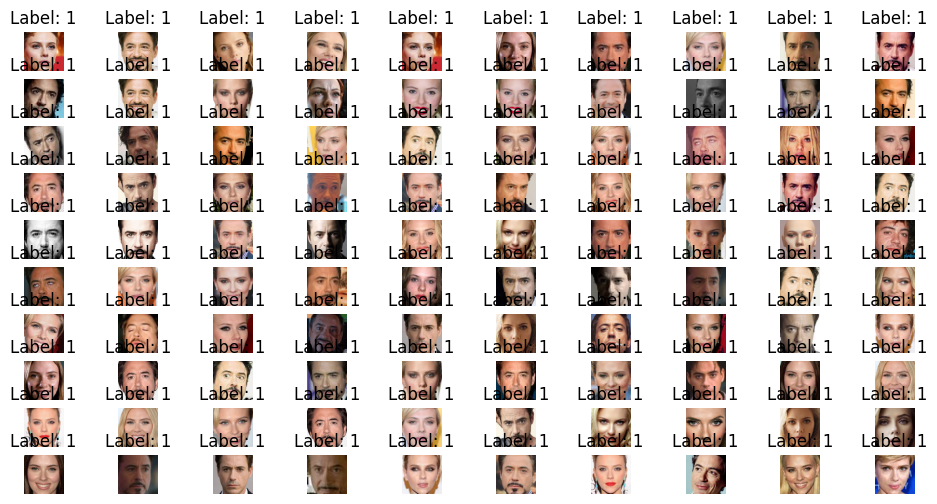

In [15]:
num_images_to_display = len(images)
fig, axes = plt.subplots(10, 10, figsize=(12, 6))
num = 0
row = 0
for i in range(num_images_to_display):
    if (num == 100):
      break
    if(labels[i] == 1):
        numUsed = num-((row)*10)
        axes[row][numUsed].imshow(images[i])
        axes[row][numUsed].set_title(f"Label: {labels[i]}")
        axes[row][numUsed].axis('off')
        num+=1
        if (num%10)==0:
          row+=1

plt.show()

In [16]:
seq_length = 26244
X_train_rnn = X_train.reshape(-1, seq_length, 1)
X_test_rnn = X_test.reshape(-1, seq_length, 1)

In [17]:
model = Sequential()
model.add(SimpleRNN(128, input_shape=(seq_length, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Perform K-Fold cross-validation
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_accuracy = []
fold_precision = []
fold_recall = []
fold_f1 = []


# for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train), 1):
for fold, (train_indices, test_indices) in enumerate(kfold.split(data_hog), 1):
    X_train, X_test = data_hog[train_indices], data_hog[test_indices]
    y_train, y_test = labels_exp[train_indices], labels_exp[test_indices]

    print(f'k-fold values : {fold} \n')

    # Reshaping data_hog for DNN (K-Fold with HOG features)
    # X_train = X_train.reshape(-1, len(data_hog[0]), 1)
    # X_test = X_test.reshape(-1, len(data_hog[0]), 1)

    # Build and train the DNN model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_rnn, y_train, batch_size=32, epochs=5, validation_data=(X_test_rnn, y_test))
    print('\n')
    # Evaluate the model on the test set
    y_pred = model.predict(X_test_rnn)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    # Display the evaluation metrics
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1-score: {:.2f}".format(f1))

    print('\n')


    # Evaluate the model on the test set
    accuracy = model.evaluate(X_test_rnn, y_test)[1]
    fold_accuracy.append(accuracy)
    fold_precision.append(precision)  # Store precision for this fold
    fold_recall.append(recall)  # Store recall for this fold
    fold_f1.append(f1)  # Store F1-score for this fold

    print('\n')

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracy)
average_precision = np.mean(fold_precision)
average_recall = np.mean(fold_recall)
average_f1 = np.mean(fold_f1)

print("Average Accuracy: {:.2f}%".format(average_accuracy * 100))
print("Average Precision: {:.2f}".format(average_precision))
print("Average Recall: {:.2f}".format(average_recall))
print("Average F1-score: {:.2f}".format(average_f1))

k-fold values : 1 

Epoch 1/5
37/37 [==============================] - 289s 8s/step - loss: 0.6225 - accuracy: 0.6954 - val_loss: 0.6271 - val_accuracy: 0.6907
Epoch 2/5
37/37 [==============================] - 258s 7s/step - loss: 0.6043 - accuracy: 0.7220 - val_loss: 0.6238 - val_accuracy: 0.6907
Epoch 3/5
37/37 [==============================] - 276s 7s/step - loss: 0.6014 - accuracy: 0.7229 - val_loss: 0.6358 - val_accuracy: 0.6942
Epoch 4/5
37/37 [==============================] - 257s 7s/step - loss: 0.6151 - accuracy: 0.7074 - val_loss: 0.6236 - val_accuracy: 0.6907
Epoch 5/5
37/37 [==============================] - 253s 7s/step - loss: 0.5970 - accuracy: 0.7229 - val_loss: 0.6345 - val_accuracy: 0.6907


10/10 [==============================] - 18s 2s/step
Accuracy: 69.07%
Precision: 0.00
Recall: 0.00
F1-score: 0.00




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 18s 2s/step - loss: 0.6345 - accuracy: 0.6907


k-fold values : 2 

Epoch 1/5
34/37 [==========================>...] - ETA: 19s - loss: 0.6115 - accuracy: 0.7105